In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
!pip install xgboost

## Fraud Dectection trong giao dịch và thanh toán

In [2]:
# Download file từ đây: https://drive.google.com/file/d/1kVWmFhMjFpm6lWBPWEhbrK8yt2Z3v91p/view
data_url = 'PS_20174392719_1491204439457_log.csv.zip'
paysim = pd.read_csv(data_url, compression='zip')

display(
    paysim.info(),
    paysim.head()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


None

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Diễn giải ý nghĩa các cột

- `step` - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- `type` - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- `amount` -
amount of the transaction in local currency.

- `nameOrig` - customer who started the transaction

- `oldbalanceOrg` - initial balance before the transaction

- `newbalanceOrig` - new balance after the transaction

- `nameDest` - customer who is the recipient of the transaction

- `oldbalanceDest` - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- `newbalanceDest` - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- `isFraud` - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- `isFlaggedFraud` - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [3]:
pd.crosstab(paysim['type'], paysim['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [4]:
paysim_cash_out = paysim[paysim['type'].eq('CASH_OUT')]
paysim_cash_out

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.00,2415.16,0,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.00,64106.18,0,0
48,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.00,6453430.91,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1,0
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1,0
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0


In [5]:
paysim_transfer = paysim[paysim['type'].eq('TRANSFER')]
paysim_transfer

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0


In [6]:
# model_data = paysim[paysim['type'].isin(['CASH_OUT', 'TRANSFER'])]
# model_data

In [7]:
### Nghĩ ra ý tưởng để tạo thêm thông tin từ dữ liệu gốc (phân tích dữ liệu để phái sinh biến)

<AxesSubplot:xlabel='amount', ylabel='Probability'>

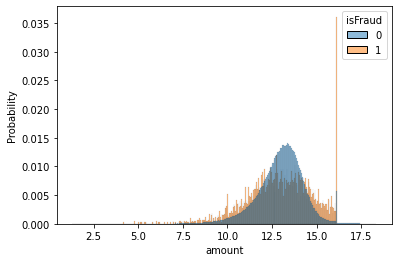

In [8]:
sns.histplot(
    # data=paysim_transfer,
    x=np.log1p(paysim_transfer['amount']),
    hue=paysim_transfer['isFraud'],
    stat='probability',
    common_norm=False
)

In [9]:
# Ý tưởng của bạn Trâm: 
# 1. tính tốc độ giao dịch_khác biệt về thời gian giữa giao dịch hiện tại và giao dịch trước đó
# 2. Khác biệt về số tiền
# Ý tưởng của bạn Thương
# 3. Tính giá trị giao dịch và số lượng giao dịch trong một thời gian ngắn 
# Ý tưởng của bạn Thái
# 4. Tính giá trị giao dịch so với số dư bắt đầu (hoặc ngược lại, số dư còn lại/số dư ban đầu)


In [10]:
name_orig = paysim_transfer['nameOrig'].unique()
name_orig

array(['C1305486145', 'C1670993182', 'C1984094095', ..., 'C2013999242',
       'C1529008245', 'C1685995037'], dtype=object)

In [11]:
paysim_transfer['nameOrig'].value_counts()

C683822340     2
C1991760030    2
C1886544249    2
C1463235060    2
C1162384917    2
              ..
C225453745     1
C595147259     1
C1524339667    1
C956283219     1
C1685995037    1
Name: nameOrig, Length: 532839, dtype: int64

In [12]:
paysim_transfer[paysim_transfer['nameOrig'].eq('C1991760030')]['step'].diff() # Không nên làm thế này

1397566     NaN
2726926    73.0
Name: step, dtype: float64

In [13]:
paysim_transfer.groupby('nameOrig', sort=False)['step'].diff()

2         NaN
19        NaN
24        NaN
58        NaN
78        NaN
           ..
6362610   NaN
6362612   NaN
6362614   NaN
6362616   NaN
6362618   NaN
Name: step, Length: 532909, dtype: float64

In [14]:
paysim_transfer['nameDest'].value_counts()

C665576141     31
C1286084959    30
C863811613     28
C97730845      26
C248609774     26
               ..
C1395427911     1
C49904924       1
C217853467      1
C628850121      1
C2080388513     1
Name: nameDest, Length: 237006, dtype: int64

In [15]:
# Tính tốc độ giao dịch
step_diff = paysim_transfer.groupby('nameDest', sort=False)['step'].diff()
step_diff

2         NaN
19        NaN
24        NaN
58        NaN
78        NaN
           ..
6362610   NaN
6362612   NaN
6362614   NaN
6362616   NaN
6362618   NaN
Name: step, Length: 532909, dtype: float64

In [16]:
# Tính khác biệt về số tiền
amount_diff = paysim_transfer.groupby('nameDest', sort=False)['amount'].diff()
amount_diff

2         NaN
19        NaN
24        NaN
58        NaN
78        NaN
           ..
6362610   NaN
6362612   NaN
6362614   NaN
6362616   NaN
6362618   NaN
Name: amount, Length: 532909, dtype: float64

In [17]:
# Tính số lượng và giá trị giao dịch trong tgian ngắn -> vì step ko ở dạng ngày tháng nên có
# thể chuyển sang tính giá trị giao dịch trong 2-5 giao dịch trước đấy
amount_rolling_2 = paysim_transfer.groupby('nameDest', sort=False).rolling(2)['amount'].sum()
amount_rolling_2

nameDest            
C553264065   2                 NaN
             6167        110166.65
             62736      1557307.86
             425019     1448813.69
             704677       49881.37
                           ...    
C1812552860  6362610           NaN
C1470998563  6362612           NaN
C1850423904  6362614           NaN
C1881841831  6362616           NaN
C2080388513  6362618           NaN
Name: amount, Length: 532909, dtype: float64

In [18]:
amount_rolling_2.droplevel(0).fillna(0)

2                0.00
6167        110166.65
62736      1557307.86
425019     1448813.69
704677       49881.37
              ...    
6362610          0.00
6362612          0.00
6362614          0.00
6362616          0.00
6362618          0.00
Name: amount, Length: 532909, dtype: float64

In [19]:
# có thể thử chuyển dữ liệu step sang dạng ngày tháng để rolling bằng cách, cộng một ngày cố định vào step
pd.Timestamp('2021-11-22') + paysim_transfer['step'].apply(lambda x: pd.Timedelta(x, 'H'))

# .rolling('1H', on='TRANS_TIME')

2         2021-11-22 01:00:00
19        2021-11-22 01:00:00
24        2021-11-22 01:00:00
58        2021-11-22 01:00:00
78        2021-11-22 01:00:00
                  ...        
6362610   2021-12-22 22:00:00
6362612   2021-12-22 23:00:00
6362614   2021-12-22 23:00:00
6362616   2021-12-22 23:00:00
6362618   2021-12-22 23:00:00
Name: step, Length: 532909, dtype: datetime64[ns]

In [20]:
paysim_transfer

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0


In [21]:
trans_amount_account_bal = paysim_transfer['amount'].div(paysim_transfer['oldbalanceOrg'])
old_new_account_bal = paysim_transfer['newbalanceOrig'].div(paysim_transfer['oldbalanceOrg'])

In [22]:
trans_amount_account_bal

2            1.000000
19         305.404681
24          28.766580
58           0.791400
78           4.121469
              ...    
6362610      1.000000
6362612      1.000000
6362614      1.000000
6362616      1.000000
6362618      1.000000
Length: 532909, dtype: float64

In [23]:
old_new_account_bal

2          0.0000
19         0.0000
24         0.0000
58         0.2086
78         0.0000
            ...  
6362610    0.0000
6362612    0.0000
6362614    0.0000
6362616    0.0000
6362618    0.0000
Length: 532909, dtype: float64

In [24]:
paysim = paysim_transfer.assign(
    trans_amount_account_bal=trans_amount_account_bal,
    old_new_account_bal=old_new_account_bal.fillna(0),
    amount_rolling_2=amount_rolling_2.droplevel(0).fillna(0),
    step_diff=step_diff.fillna(0),
    amount_diff=amount_diff.fillna(0),
    log_amount=lambda x: np.log1p(x['amount'])
)
paysim

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,trans_amount_account_bal,old_new_account_bal,amount_rolling_2,step_diff,amount_diff,log_amount
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,1.000000,0.0000,0.0,0.0,0.0,5.204007
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,305.404681,0.0000,0.0,0.0,0.0,12.279840
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,28.766580,0.0000,0.0,0.0,0.0,12.649754
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0,0.791400,0.2086,0.0,0.0,0.0,11.044709
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0,4.121469,0.0000,0.0,0.0,0.0,10.662268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0,1.000000,0.0000,0.0,0.0,0.0,11.057503
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0,1.000000,0.0000,0.0,0.0,0.0,14.045685
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0,1.000000,0.0000,0.0,0.0,0.0,12.735768
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,1.000000,0.0000,0.0,0.0,0.0,15.657870


In [25]:
drop_cols = ['step', 'type', 'nameOrig', 'nameDest', 'isFlaggedFraud']
model_data = paysim.drop(columns=drop_cols)
model_data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,trans_amount_account_bal,old_new_account_bal,amount_rolling_2,step_diff,amount_diff,log_amount
2,181.00,181.00,0.0,0.00,0.00,1,1.000000,0.0000,0.0,0.0,0.0,5.204007
19,215310.30,705.00,0.0,22425.00,0.00,0,305.404681,0.0000,0.0,0.0,0.0,12.279840
24,311685.89,10835.00,0.0,6267.00,2719172.89,0,28.766580,0.0000,0.0,0.0,0.0,12.649754
58,62610.80,79114.00,16503.2,517.00,8383.29,0,0.791400,0.2086,0.0,0.0,0.0,11.044709
78,42712.39,10363.39,0.0,57901.66,24044.18,0,4.121469,0.0000,0.0,0.0,0.0,10.662268
...,...,...,...,...,...,...,...,...,...,...,...,...
6362610,63416.99,63416.99,0.0,0.00,0.00,1,1.000000,0.0000,0.0,0.0,0.0,11.057503
6362612,1258818.82,1258818.82,0.0,0.00,0.00,1,1.000000,0.0000,0.0,0.0,0.0,14.045685
6362614,339682.13,339682.13,0.0,0.00,0.00,1,1.000000,0.0000,0.0,0.0,0.0,12.735768
6362616,6311409.28,6311409.28,0.0,0.00,0.00,1,1.000000,0.0000,0.0,0.0,0.0,15.657870


In [26]:
X_data, Y_data = model_data.drop(columns=['isFraud']), model_data['isFraud']

In [27]:
X_data.isna().sum(axis=0)

amount                      0
oldbalanceOrg               0
newbalanceOrig              0
oldbalanceDest              0
newbalanceDest              0
trans_amount_account_bal    0
old_new_account_bal         0
amount_rolling_2            0
step_diff                   0
amount_diff                 0
log_amount                  0
dtype: int64

In [28]:
X_data.abs().eq(np.inf).sum(axis=0)

amount                           0
oldbalanceOrg                    0
newbalanceOrig                   0
oldbalanceDest                   0
newbalanceDest                   0
trans_amount_account_bal    282783
old_new_account_bal              0
amount_rolling_2                 0
step_diff                        0
amount_diff                      0
log_amount                       0
dtype: int64

In [29]:
X_data['trans_amount_account_bal'] = \
    X_data['trans_amount_account_bal'].where(X_data['trans_amount_account_bal'].abs().ne(np.inf), 0)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3)

In [32]:
svc = SVC()
svc.fit(x_train, y_train)

SVC()

In [33]:
import pickle

In [34]:
with open('svc.model', 'wb') as f:
    pickle.dump(svc, f) # lưu mô hình dưới dạng file

In [35]:
with open('svc.model', 'rb') as f:
    print(pickle.load(f)) # đọc lại từ file

SVC()


In [36]:
y_pred = svc.predict(x_test)
display(
    metrics.accuracy_score(y_test, y_pred),
    metrics.precision_score(y_test, y_pred),
    metrics.recall_score(y_test, y_pred),
    metrics.f1_score(y_test, y_pred),
)

0.9960969019158957

0.9857594936708861

0.5032310177705978

0.6663101604278076

In [37]:
tree = RandomForestClassifier()
tree.fit(x_train, y_train)

RandomForestClassifier()

In [38]:
y_pred = tree.predict(x_test)
display(
    metrics.accuracy_score(y_test, y_pred),
    metrics.precision_score(y_test, y_pred),
    metrics.recall_score(y_test, y_pred),
    metrics.f1_score(y_test, y_pred),
)

0.9999874900702432

1.0

0.9983844911147012

0.9991915925626517

## Giới thiệu XGBoost
![](https://www.researchgate.net/publication/348025909/figure/fig2/AS:1020217916416002@1620250314481/Simplified-structure-of-XGBoost.ppm)

In [39]:
from xgboost import XGBClassifier

In [40]:
XGBClassifier?

Init signature:
XGBClassifier(
    *,
    objective='binary:logistic',
    use_label_encoder=True,
    **kwargs,
)
Docstring:     
Implementation of the scikit-learn API for XGBoost classification.


Parameters
----------

    n_estimators : int
        Number of boosting rounds.
    use_label_encoder : bool
        (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new
        code, we recommend that you set this parameter to False.

    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    verbosity : int
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    tree_method: string
        Specify 

In [41]:
xg = XGBClassifier()
xg.fit(x_train, y_train)

C:\Users\tdoan\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
y_pred = xg.predict(x_test)
display(
    metrics.accuracy_score(y_test, y_pred),
    metrics.precision_score(y_test, y_pred),
    metrics.recall_score(y_test, y_pred),
    metrics.f1_score(y_test, y_pred),
)

NameError: name 'xg' is not defined

# Re-Practice

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url = '/Users/trang/Documents/python/Python_2/PS_log.csv.zip'
paysin = pd.read_csv(url, compression = 'zip')
display(
    paysin.info(),
    paysin.head(10)
)    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


None

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [3]:
paysin.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
columns = paysin.columns.drop(['isFraud','isFlaggedFraud'])

In [5]:
pd.crosstab(paysin['type'], paysin['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [6]:
paysin_cash_out = paysin[paysin['type'].eq('CASH_OUT')]
paysin_cash_out

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.00,2415.16,0,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.00,64106.18,0,0
48,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.00,6453430.91,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1,0
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1,0
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0


In [5]:
paysin_transfer = paysin[paysin['type'].eq('TRANSFER')]
paysin_transfer

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0


In [42]:
model_data = paysin[paysin['type'].isin(['CASH_OUT','TRANSFER'])]
model_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


<AxesSubplot:xlabel='amount', ylabel='Probability'>

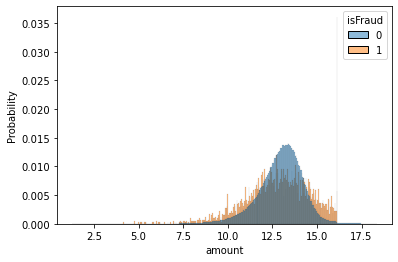

In [8]:
sns.histplot(
    data = paysin_transfer,
    x = np.log1p(paysin_transfer['amount']),
    hue = 'isFraud',
    stat = 'probability',
    common_norm = False
)

## tính tốc độ giao dịch (sender/rece)

In [6]:
# lấy unique các name 
name_orig = paysin_transfer['nameOrig'].unique()
name_orig

array(['C1305486145', 'C1670993182', 'C1984094095', ..., 'C2013999242',
       'C1529008245', 'C1685995037'], dtype=object)

In [7]:
# group by giao dịch của từng người gửi
paysin_transfer.groupby('nameOrig', sort = False)['step'].diff()

2         NaN
19        NaN
24        NaN
58        NaN
78        NaN
           ..
6362610   NaN
6362612   NaN
6362614   NaN
6362616   NaN
6362618   NaN
Name: step, Length: 532909, dtype: float64

In [8]:
paysin_transfer['nameDest'].value_counts()

C665576141     31
C1286084959    30
C863811613     28
C248609774     26
C97730845      26
               ..
C1661807660     1
C1147684106     1
C1066799365     1
C2004566460     1
C1626543342     1
Name: nameDest, Length: 237006, dtype: int64

In [9]:
# group by giao dịch của từng người nhận
step_diff = paysin_transfer.groupby('nameDest', sort = False)['step'].diff()
step_diff

2         NaN
19        NaN
24        NaN
58        NaN
78        NaN
           ..
6362610   NaN
6362612   NaN
6362614   NaN
6362616   NaN
6362618   NaN
Name: step, Length: 532909, dtype: float64

In [10]:
# tính khác biệt số tiền giao dịch
amount_diff = paysin_transfer.groupby('nameDest', sort = False)['amount'].diff()
amount_diff

2         NaN
19        NaN
24        NaN
58        NaN
78        NaN
           ..
6362610   NaN
6362612   NaN
6362614   NaN
6362616   NaN
6362618   NaN
Name: amount, Length: 532909, dtype: float64

In [17]:
# tính số lượng và giá trị giao dịch trong 1 thời gian ngắn
transition_num = paysin_transfer.groupby('nameDest', sort = False).rolling().count()
transition_num

ValueError: window must be an integer

In [11]:
rolling_sum = paysin_transfer.groupby('nameDest', sort = False).rolling(2)['amount'].sum()
rolling_sum

nameDest            
C553264065   2                 NaN
             6167        110166.65
             62736      1557307.86
             425019     1448813.69
             704677       49881.37
                           ...    
C1812552860  6362610           NaN
C1470998563  6362612           NaN
C1850423904  6362614           NaN
C1881841831  6362616           NaN
C2080388513  6362618           NaN
Name: amount, Length: 532909, dtype: float64

In [12]:
# chuyển dữ liêun step sang ngày tháng để rolling 
# công 1 ngày cố định vào step
# đổi step sang dạng thời gian: vd 1h
date = pd.Timestamp('2021-10-20') + paysin_transfer['step'].apply(lambda x:pd.Timedelta(x,'H')) 
date

2         2021-10-20 01:00:00
19        2021-10-20 01:00:00
24        2021-10-20 01:00:00
58        2021-10-20 01:00:00
78        2021-10-20 01:00:00
                  ...        
6362610   2021-11-19 22:00:00
6362612   2021-11-19 23:00:00
6362614   2021-11-19 23:00:00
6362616   2021-11-19 23:00:00
6362618   2021-11-19 23:00:00
Name: step, Length: 532909, dtype: datetime64[ns]

In [23]:

paysin_transfer['TRANS_TIME'] = date
paysin_transfer


<ipython-input-23-a004dc7cb429>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paysin_transfer['TRANS_TIME'] = date


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,TRANS_TIME
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,2021-10-20 01:00:00
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,2021-10-20 01:00:00
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,2021-10-20 01:00:00
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0,2021-10-20 01:00:00
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0,2021-10-20 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0,2021-11-19 22:00:00
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0,2021-11-19 23:00:00
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0,2021-11-19 23:00:00
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,2021-11-19 23:00:00


In [24]:
# rolling số lượng giao dịch trong 1h
trans_count_1h = paysin_transfer.groupby('nameDest', sort = False).rolling('1H', on = 'TRANS_TIME')['step'].count()
trans_count_1h

nameDest     TRANS_TIME         
C553264065   2021-10-20 01:00:00    1.0
             2021-10-20 06:00:00    1.0
             2021-10-20 09:00:00    1.0
             2021-10-20 18:00:00    1.0
             2021-10-21 13:00:00    1.0
                                   ... 
C1812552860  2021-11-19 22:00:00    1.0
C1470998563  2021-11-19 23:00:00    1.0
C1850423904  2021-11-19 23:00:00    1.0
C1881841831  2021-11-19 23:00:00    1.0
C2080388513  2021-11-19 23:00:00    1.0
Name: step, Length: 532909, dtype: float64

In [25]:
# tính giá trị giao dịch: số dư còn lại, số dư bắt đầu
trans_amount_acount_bal = paysin_transfer['amount'].div(paysin_transfer['oldbalanceOrg'])
trans_amount_acount_bal

2            1.000000
19         305.404681
24          28.766580
58           0.791400
78           4.121469
              ...    
6362610      1.000000
6362612      1.000000
6362614      1.000000
6362616      1.000000
6362618      1.000000
Length: 532909, dtype: float64

In [26]:
old_new_acount_bal = paysin_transfer['newbalanceOrig'].div(paysin_transfer['oldbalanceOrg'])
old_new_acount_bal 

2          0.0000
19         0.0000
24         0.0000
58         0.2086
78         0.0000
            ...  
6362610    0.0000
6362612    0.0000
6362614    0.0000
6362616    0.0000
6362618    0.0000
Length: 532909, dtype: float64

In [27]:
new_paysin = paysin_transfer.assign(
    trans_amount_acount_bal = trans_amount_acount_bal,
    old_new_acount_bal = old_new_acount_bal.fillna(0),
    amount_rolling_2 = rolling_sum.droplevel(0).fillna(0),
    amount_diff = amount_diff.fillna(0),
    step_diff = step_diff.fillna(0),
    log_amount = lambda x: np.log1p(x['amount'])
)
new_paysin

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,TRANS_TIME,trans_amount_acount_bal,old_new_acount_bal,amount_rolling_2,amount_diff,step_diff,log_amount
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,2021-10-20 01:00:00,1.000000,0.0000,0.0,0.0,0.0,5.204007
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,2021-10-20 01:00:00,305.404681,0.0000,0.0,0.0,0.0,12.279840
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,2021-10-20 01:00:00,28.766580,0.0000,0.0,0.0,0.0,12.649754
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0,2021-10-20 01:00:00,0.791400,0.2086,0.0,0.0,0.0,11.044709
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0,2021-10-20 01:00:00,4.121469,0.0000,0.0,0.0,0.0,10.662268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0,2021-11-19 22:00:00,1.000000,0.0000,0.0,0.0,0.0,11.057503
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0,2021-11-19 23:00:00,1.000000,0.0000,0.0,0.0,0.0,14.045685
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0,2021-11-19 23:00:00,1.000000,0.0000,0.0,0.0,0.0,12.735768
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0,2021-11-19 23:00:00,1.000000,0.0000,0.0,0.0,0.0,15.657870


In [28]:
# đổi infinity
new_paysin['trans_amount_acount_bal'] = new_paysin['trans_amount_acount_bal'].where(new_paysin['trans_amount_acount_bal'].abs().ne(np.inf), 0)

In [29]:
rolling_sum.droplevel(0).fillna(0)

2                0.00
6167        110166.65
62736      1557307.86
425019     1448813.69
704677       49881.37
              ...    
6362610          0.00
6362612          0.00
6362614          0.00
6362616          0.00
6362618          0.00
Name: amount, Length: 532909, dtype: float64

In [30]:
col_name = new_paysin.columns.drop(['step','type', 'nameOrig','nameDest', 'isFlaggedFraud','TRANS_TIME', 'isFraud' ])
col_name

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'trans_amount_acount_bal', 'old_new_acount_bal',
       'amount_rolling_2', 'amount_diff', 'step_diff', 'log_amount'],
      dtype='object')

In [31]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [32]:
X, y = new_paysin[col_name], new_paysin['isFraud']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [31]:
svc = SVC()
svc.fit(x_train, y_train)

SVC()

In [32]:
y_pred = svc.predict(x_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
display(
    metrics.accuracy_score(y_test, y_pred),
    metrics.precision_score(y_test, y_pred),
    metrics.recall_score(y_test, y_pred),
    metrics.f1_score(y_test, y_pred)
)

0.9961281767402876

0.9872813990461049

0.5040584415584416

0.6673831273508867

In [36]:
forest = RandomForestClassifier()
forest.fit(x_train, y_train)

RandomForestClassifier()

In [37]:
y_pred2 = forest.predict(x_test)
y_pred2

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
display(
    metrics.accuracy_score(y_test, y_pred2),
    metrics.precision_score(y_test, y_pred2),
    metrics.recall_score(y_test, y_pred2),
    metrics.f1_score(y_test, y_pred2)
)

0.9999687251756081

0.9975669099756691

0.9983766233766234

0.9979716024340771

# XGBoost
sử dụng sai số tại lần train trước làm đầu vào cho các lần train sau

In [1]:
from xgboost import XGBClassifier

In [ ]:
# pickle : Lưu model lại
import pickle
pickle.dum(svc, 'SCV_model')

#đọc ngược lại mô hình
svc = pickle.load('SVC_model')